<a href="https://colab.research.google.com/github/fboldt/aulasml/blob/master/aula8a_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
data = pd.read_csv("train.csv")
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
y = data['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [4]:
X = data.drop('Survived', axis=1)
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
for column in X.columns:
  print(f"{column:>12} {len(set(X[column])):4} {X[column].dtype}")

 PassengerId  891 int64
      Pclass    3 int64
        Name  891 object
         Sex    2 object
         Age  265 float64
       SibSp    7 int64
       Parch    7 int64
      Ticket  681 object
        Fare  248 float64
       Cabin  148 object
    Embarked    4 object


In [6]:
indesejadas = ['PassengerId','Name','Ticket','Cabin']
Xdrop = X.drop(indesejadas, axis=1)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [7]:
Xnum = Xdrop.select_dtypes('number')
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [8]:
for column in Xnum.columns:
  print(f"{column:>12} {sum(Xnum[column].isnull())}")

      Pclass 0
         Age 177
       SibSp 0
       Parch 0
        Fare 0


In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
XnumLimpo = imputer.fit_transform(Xnum)
XnumLimpo

array([[ 3.    , 22.    ,  1.    ,  0.    ,  7.25  ],
       [ 1.    , 38.    ,  1.    ,  0.    , 71.2833],
       [ 3.    , 26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [ 3.    , 28.    ,  1.    ,  2.    , 23.45  ],
       [ 1.    , 26.    ,  0.    ,  0.    , 30.    ],
       [ 3.    , 32.    ,  0.    ,  0.    ,  7.75  ]])

In [10]:
Xcat = Xdrop.select_dtypes('object')
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [11]:
for column in Xcat.columns:
  print(f"{column:>12} {sum(Xcat[column].isnull())}")

         Sex 0
    Embarked 2


In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
XcatLimpo = imputer.fit_transform(Xcat)
XcatLimpo

array([['male', 'S'],
       ['female', 'C'],
       ['female', 'S'],
       ...,
       ['female', 'S'],
       ['male', 'C'],
       ['male', 'Q']], dtype=object)

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder  = OneHotEncoder()
XcatHot = encoder.fit_transform(XcatLimpo)
XcatHot

<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [14]:
import numpy as np
Xtratado = np.c_[XnumLimpo, XcatHot.toarray()]
Xtratado.shape

(891, 10)

In [15]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.columns.isin(test.columns)

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [17]:
train.columns[~train.columns.isin(test.columns)]

Index(['Survived'], dtype='object')

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosDesejados(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasIndesejadas_ = ['PassengerId','Name','Ticket','Cabin']
    return self
  def transform(self, X, y=None):
    return X.drop(self.colunasIndesejadas_, axis=1)

atributosDesejados = AtributosDesejados()
Xdrop = atributosDesejados.fit_transform(X)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosNumericos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasNumericas = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasNumericas]

atributosNumericos = AtributosNumericos()
Xnum = atributosNumericos.fit_transform(Xdrop)
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipenum = Pipeline([
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

XnumLimpo = pipenum.fit_transform(Xdrop)
XnumLimpo

array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337,  2.00893337, -0.17626324],
       [-1.56610693, -0.25833709, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.82737724,  0.20276197, -0.4745452 , -0.47367361, -0.49237783]])

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasCategoricas = X.select_dtypes(include='object').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasCategoricas]

atributosCategoricos = AtributosCategoricos()
Xcat = atributosCategoricos.fit_transform(Xdrop)
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pipecat = Pipeline([
    ('atributos_categoricos', AtributosCategoricos()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

XcatLimpo = pipecat.fit_transform(Xdrop)
XcatLimpo

<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.pipeline import FeatureUnion

unecaracteristicas = FeatureUnion([
    ('pipenum', pipenum),
    ('pipecat', pipecat)
])

Xtratado = unecaracteristicas.fit_transform(Xdrop)
Xtratado

<891x10 sparse matrix of type '<class 'numpy.float64'>'
	with 6237 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.pipeline import Pipeline

preproc = Pipeline([
    ('atributos_desejados', AtributosDesejados()),
    ('unecaracteristicas', unecaracteristicas)
])

Xtratado = preproc.fit_transform(X)
Xtratado

<891x10 sparse matrix of type '<class 'numpy.float64'>'
	with 6237 stored elements in Compressed Sparse Row format>

In [26]:
from sklearn.tree import DecisionTreeClassifier

pipetotal = Pipeline([
    ('preproc', preproc),
    ('arvore', DecisionTreeClassifier())
])


In [27]:
from sklearn.metrics import accuracy_score

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.9797979797979798

In [28]:
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.03966427, 0.01974821, 0.02138591, 0.01774645, 0.01858997]),
  'score_time': array([0.00750327, 0.00902319, 0.00789547, 0.00991178, 0.008183  ]),
  'test_score': array([0.74860335, 0.78651685, 0.80337079, 0.7247191 , 0.80898876])},
 0.774439771514657)

In [29]:
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)
ypred

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [41]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('tree_submission.csv', index=False)

In [42]:
from sklearn.model_selection import GridSearchCV

parametros = {
    'arvore__max_depth': [None] + list(range(1,10,2)),
    'preproc__unecaracteristicas__pipenum__imputer__strategy': ['mean', 'median', 'most_frequent']
}

modelo = GridSearchCV(pipetotal, param_grid=parametros)

scores = cross_validate(modelo, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([1.45808578, 1.45618796, 1.44916797, 1.76956701, 1.56414461]),
  'score_time': array([0.00405622, 0.0043788 , 0.00400853, 0.006037  , 0.00478935]),
  'test_score': array([0.81564246, 0.82022472, 0.81460674, 0.78089888, 0.83146067])},
 0.8125666938673028)

In [43]:
modelo.fit(X, y)
modelo.best_estimator_

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('atributos_desejados', AtributosDesejados()),
                                 ('unecaracteristicas',
                                  FeatureUnion(transformer_list=[('pipenum',
                                                                  Pipeline(steps=[('atributos_numericos',
                                                                                   AtributosNumericos()),
                                                                                  ('imputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('scaler',
                                                                                   StandardScaler())])),
                                                                 ('pipecat',
                                                                  Pipeline(steps=[('atributos_categoricos',
                                                                                   AtributosCategoricos()),
                                                                                  ('imputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('encoder',
                                                                                   OneHotEncoder())]))]))])),
                ('arvore', DecisionTreeClassifier(max_depth=5))])

In [45]:
submission = pd.read_csv('gender_submission.csv')
ypred = modelo.predict(test)
submission['Survived'] = ypred
submission.to_csv('tree_submission.csv', index=False)

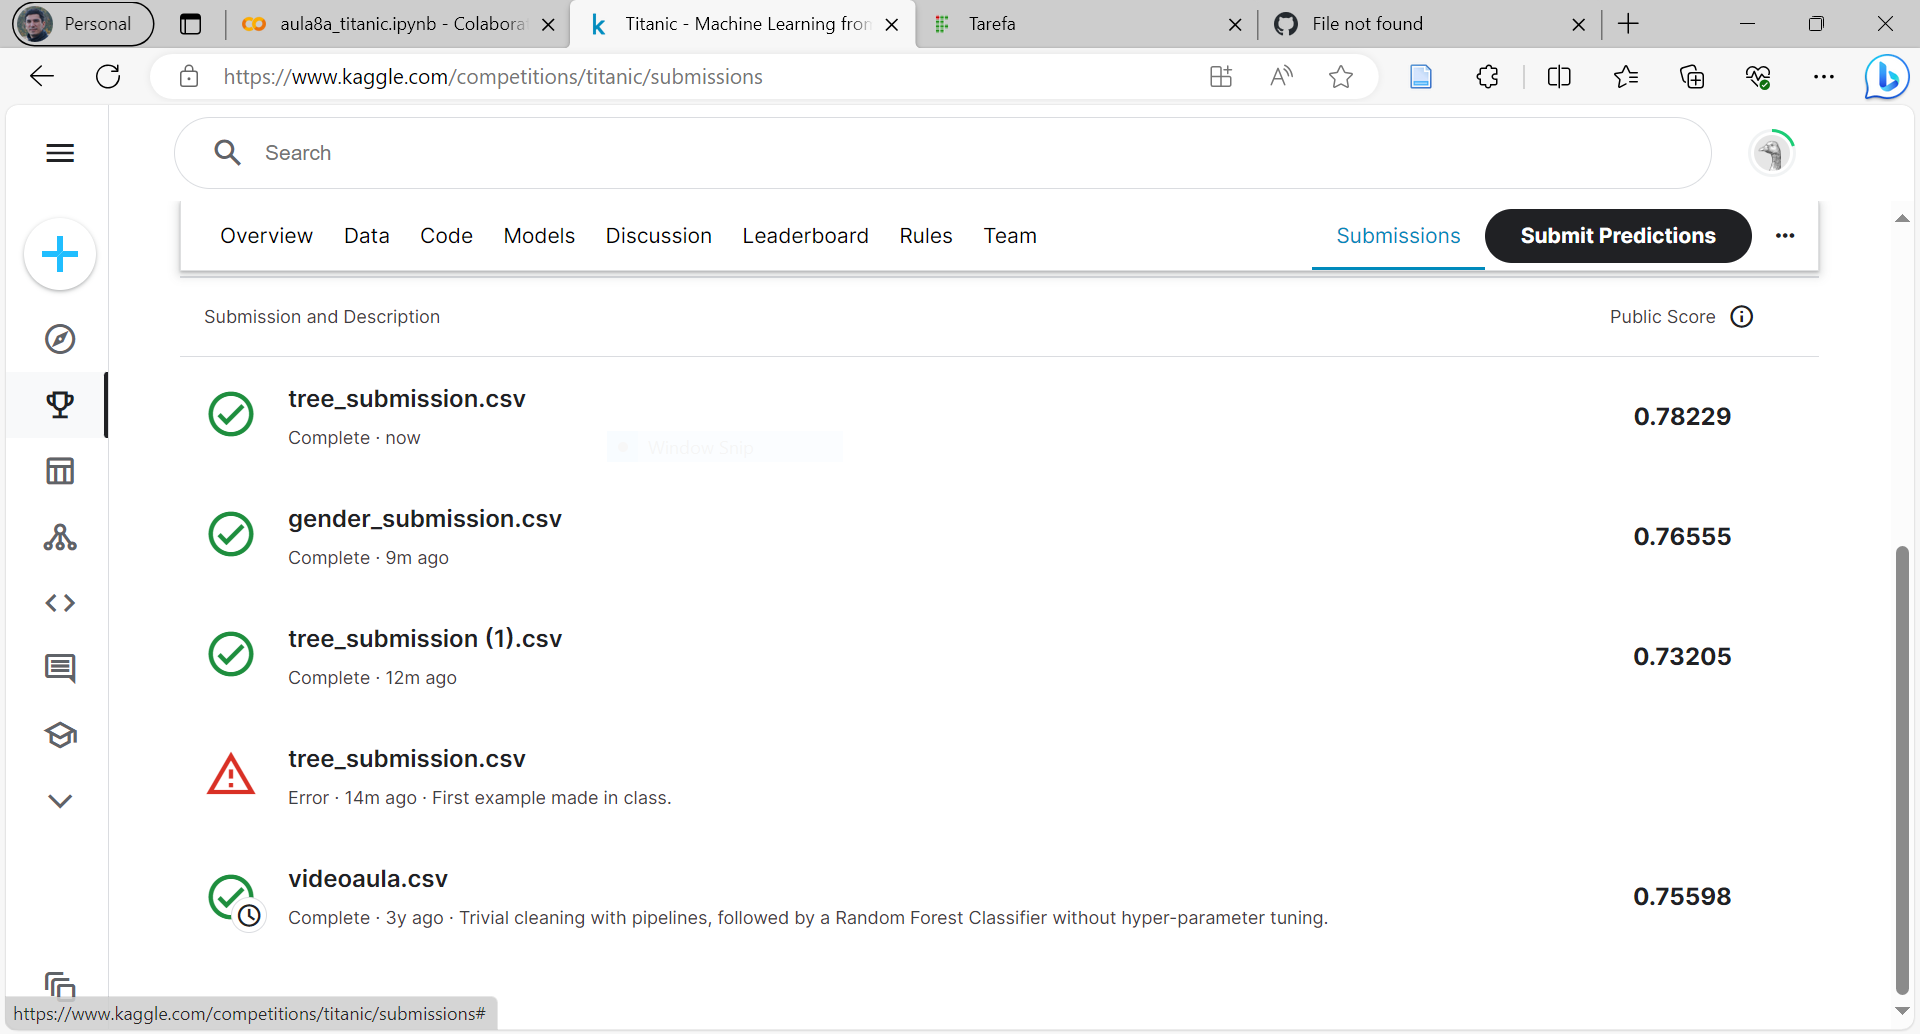

In [54]:
score = 0.78229
(score-0.65)*125

16.536250000000003